In [1]:
# Version: Python 3.9.2
# Data cleaning reference: 
# https://towardsdatascience.com/using-randomforest-to-predict-medical-appointment-no-shows-b33575e3ff42

In [2]:
# Basic package management
import pickle 
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes=True)

In [3]:
# sklean module management
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [4]:
# excel document reading
df_raw = pd.read_excel("MedicalCentre.xlsx")

# pickle document reading
# with open('df_raw.pickle','rb') as read_file:
#     df_raw = pickle.load(read_file)

# Datagram duplicate
df = df_raw.copy()

In [5]:
# dealing with missing values
df.isnull().sum() # it seems like there are no missing values

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [6]:
# determine frequency of distict values
for col in df.columns:
    print(col)
    print(df[col].value_counts(sort=True, normalize=True))
    print('\n')

PatientId
8.221459e+14    0.000796
9.963767e+10    0.000760
2.688613e+13    0.000633
3.353478e+13    0.000588
6.264199e+12    0.000561
                  ...   
8.622636e+11    0.000009
9.267587e+12    0.000009
5.764356e+12    0.000009
5.712491e+12    0.000009
1.557663e+13    0.000009
Name: PatientId, Length: 62299, dtype: float64


AppointmentID
5642903    0.000009
5692618    0.000009
5687640    0.000009
5740664    0.000009
5740598    0.000009
             ...   
5718442    0.000009
5426425    0.000009
5424230    0.000009
5720832    0.000009
5629448    0.000009
Name: AppointmentID, Length: 110527, dtype: float64


Gender
F    0.649977
M    0.350023
Name: Gender, dtype: float64


ScheduledDay
2016-05-06T07:09:54Z    0.000217
2016-05-06T07:09:53Z    0.000208
2016-04-25T17:18:27Z    0.000199
2016-04-25T17:17:46Z    0.000199
2016-04-25T17:17:23Z    0.000172
                          ...   
2016-05-02T09:53:25Z    0.000009
2016-05-30T09:12:28Z    0.000009
2016-05-16T09:10:04Z    0.000009
20

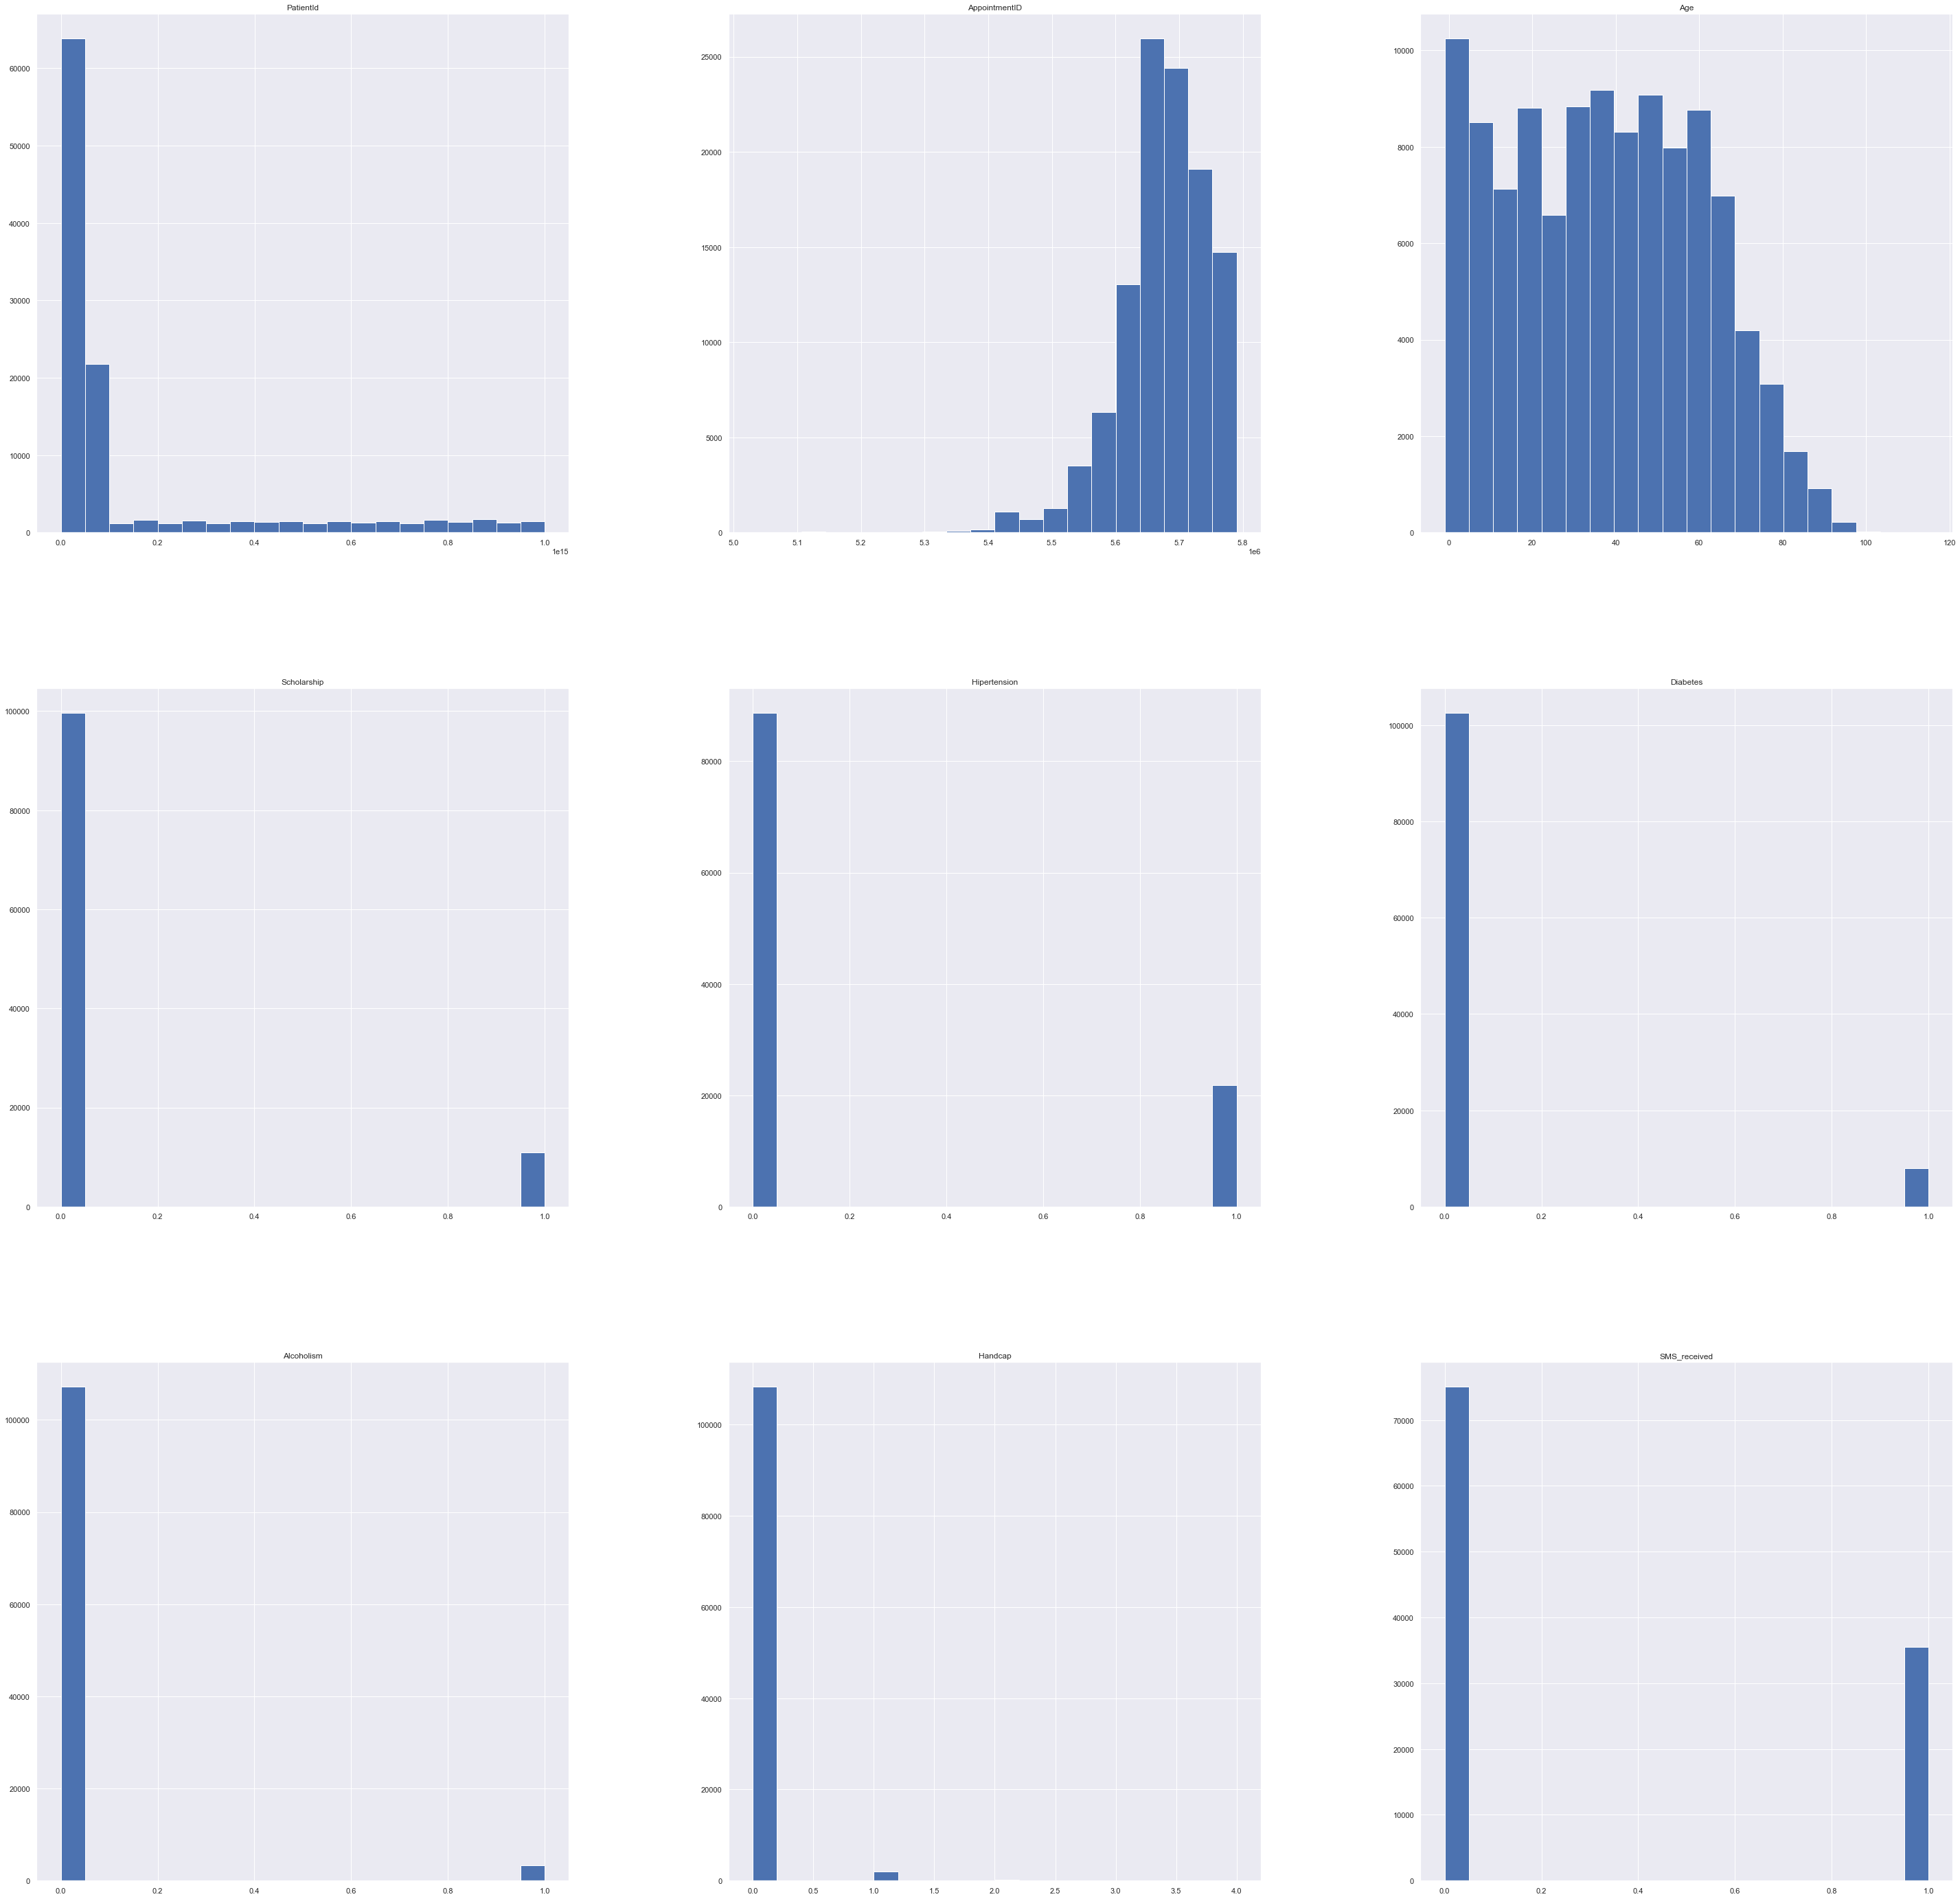

In [7]:
df.hist(bins=20,figsize=(50,50))
plt.show()

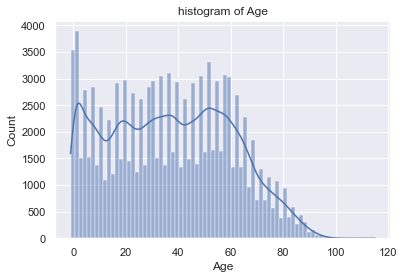

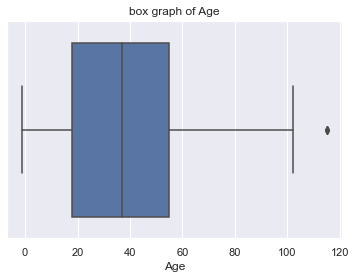

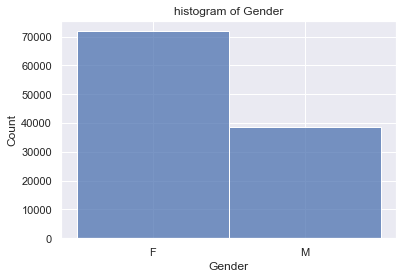

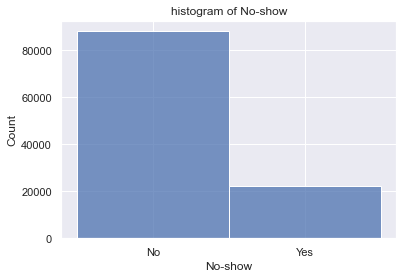

In [8]:
# plot all features to visualize outliers
plt.figure(0)
plt.title("histogram of Age")
sns.histplot(df['Age'], kde=True)
plt.show()

plt.figure(1)
plt.title("box graph of Age")
sns.boxplot(x = df['Age'])
plt.show() # there are some outliers

plt.figure(2)
plt.title("histogram of Gender")
sns.histplot(df['Gender'])
plt.show()

plt.figure(3)
plt.title("histogram of No-show")
sns.histplot(df['No-show'])
plt.show()


In [9]:
# Count the frequency of negative Age feature observations, and remove them
df['Age'] = df['Age'].astype(int)
temp = df.Age.value_counts(normalize=True)
temp = pd.DataFrame(temp)
temp = temp.reset_index()
temp.columns = ['Age', 'Frequency']

# print the frequency of negative Age feature observations
print(temp.loc[temp['Age'] < 0], '\n')
# print the frequency of Age feature observations above 100
print(temp.loc[temp['Age'] > 100])

# remove ages < 0 or > 100
# df = df[df['Age'] >= 0]
# df = df[df['Age'] <= 100]
df.loc[df['Age'] < 0] = np.nan
df.loc[df['Age'] > 100] = np.nan

df.dropna(inplace = True)


     Age  Frequency
103   -1   0.000009 

     Age  Frequency
99   115   0.000045
101  102   0.000018


In [10]:
# Datatime breakdown
df['ScheduledDay_Day'] = df['ScheduledDay'].str.split(pat='T', expand = True)[0]
df['AppointmentDay_Day'] = df['AppointmentDay'].str.split(pat='T', expand = True)[0]

df['AppointmentDay_Time'] = df['AppointmentDay'].str.split(pat='T', expand = True)[1]
df['ScheduledDay_Time'] = df['ScheduledDay'].str.split(pat='T', expand = True)[1]

df['ScheduledDay_Time'] = df['ScheduledDay_Time'].str.translate({ord('Z'): None})
df['ScheduledDay_Hours'] = df['ScheduledDay_Time'].apply(lambda x:x[0:2])

In [11]:
# Calculate the difference between the ScheduledDay and AppointmentDay
df['ScheduledDay_Day'] = pd.to_datetime(df['ScheduledDay_Day'], infer_datetime_format=True)
df['AppointmentDay_Day'] = pd.to_datetime(df['AppointmentDay_Day'], infer_datetime_format=True)

df['ScheduledDay_Date'] = df['ScheduledDay_Day'].astype(str).apply(lambda x:x[-2:])
df['AppointmentDay_Date'] = df['AppointmentDay_Day'].astype(str).apply(lambda x:x[-2:])
df['day_difference'] = (df['AppointmentDay_Day'] - df['ScheduledDay_Day']).apply(lambda x: x.days)

In [12]:
# Convert the datatime into weekday to judge if the weekday matters
df['appointment_weekday'] = df['AppointmentDay_Day'].apply(lambda x:x.isoweekday())
df['schedule_weekday'] = df['ScheduledDay_Day'].apply(lambda x:x.isoweekday())

In [13]:
# Drop NAN and convert type into int
df.loc[df['day_difference'] < 0] = np.nan
df.dropna(inplace = True)
# df = df.loc[df['day_difference'] >= 0]

df['ScheduledDay_Date'] = df['ScheduledDay_Date'].astype(int)
df['AppointmentDay_Date'] = df['AppointmentDay_Date'].astype(int)

In [14]:
# Convert time features into int
df['day_difference'] = df['day_difference'].astype(int)
df['ScheduledDay_Hours'] = df['ScheduledDay_Hours'].astype(int)
df['ScheduledDay_Date'] = df['ScheduledDay_Date'].astype(int)
df['AppointmentDay_Date'] = df['AppointmentDay_Date'].astype(int)

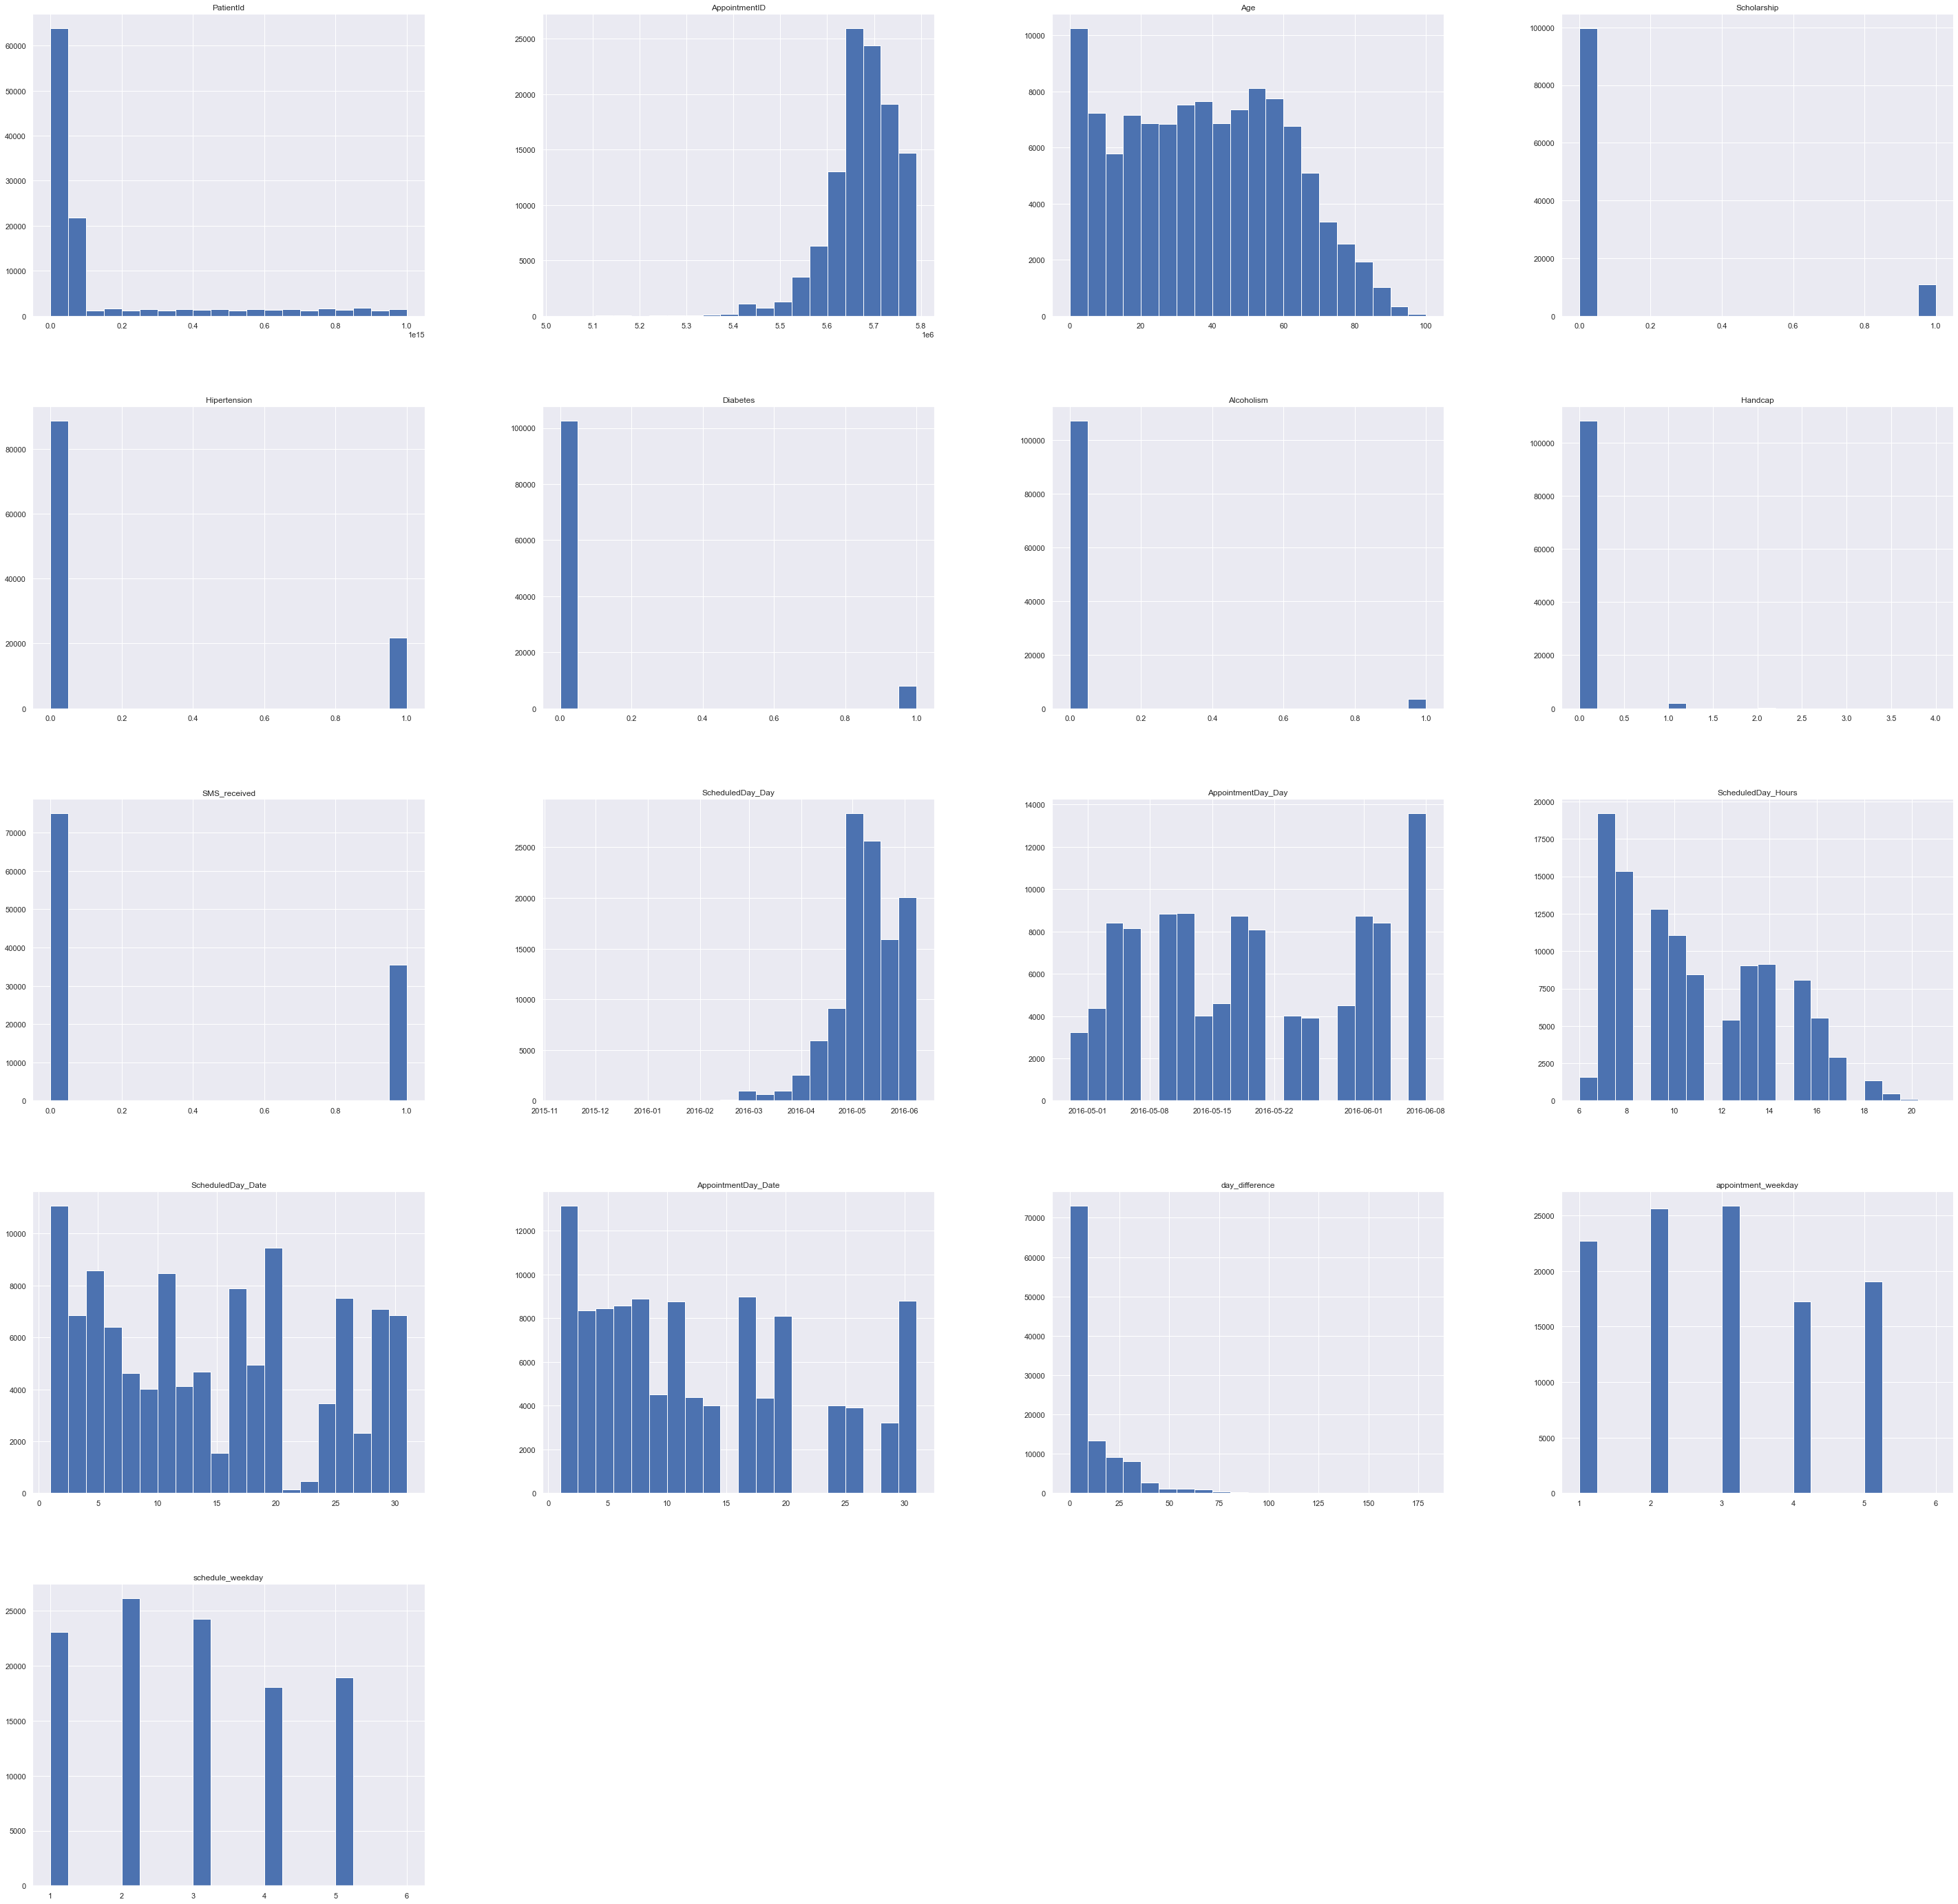

In [15]:
# visualize the new features
df.hist(bins=20,figsize=(50,50))
plt.show()

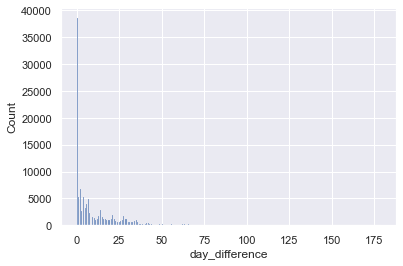

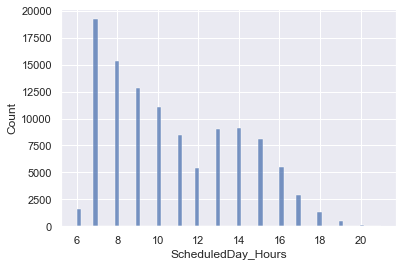

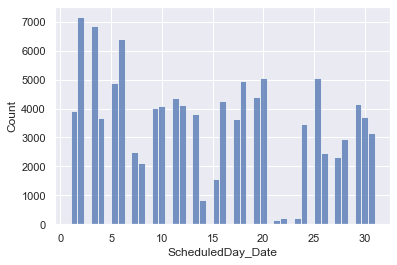

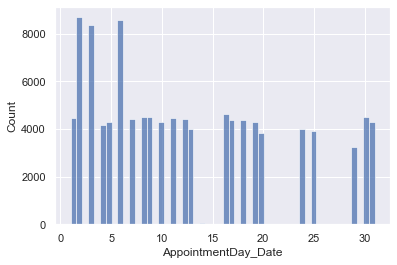

In [16]:
plt.figure(0)
sns.histplot(df['day_difference'])
plt.show()

plt.figure(1)
sns.histplot(df['ScheduledDay_Hours'])
plt.show()

plt.figure(2)
sns.histplot(df['ScheduledDay_Date'])
plt.show()

plt.figure(3)
sns.histplot(df['AppointmentDay_Date'])
plt.show()

In [17]:
# Binarize Gender, No-show and Handcap
df["Gender"] = df['Gender'].replace({'F': 0, 'M': 1}).astype(int)
df["No-show"] = df['No-show'].replace({'No': 0, 'Yes': 1}).astype(int)
df['Handcap'].replace([2,3,4],1, inplace = True)

In [18]:
# Find patients who have missed appointments more than one time and record them
appointments = df.groupby('PatientId').AppointmentID.count().reset_index()
appointments.columns = ['PatientId','prior_appointments']

# Count the number of repetitions
appointments['prior_appointments'] = appointments['prior_appointments'].apply(lambda x:x-1)
df = df.merge(appointments, how = 'left', on = 'PatientId')
no_shows = df.groupby('PatientId')['No-show'].sum().reset_index()

# Reset new column names
no_shows.columns = ['PatientId','prior_no_shows']
no_shows['prior_no_shows'] = no_shows['prior_no_shows'].apply(lambda x:x-1)
df = df.merge(no_shows, how = 'left', on = 'PatientId')

df['prior_no_shows'].replace(-1,0, inplace = True)

df.sort_values('AppointmentDay', inplace = True) 
df.drop_duplicates(subset='PatientId', keep = 'last', inplace = True)

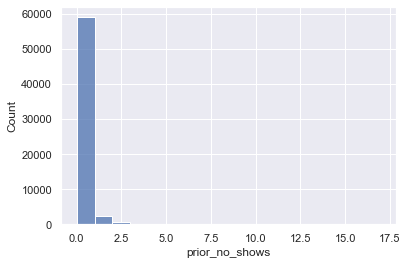

In [19]:
# visulaize the new features
plt.figure(0)
sns.histplot(df['prior_no_shows'])
plt.show()

In [20]:
# "Neighbourhood" hard encoding
# df.drop('Neighbourhood', axis=1, inplace=True)
neighbourmap = {elem:index+1 for index,elem in enumerate(set(df["Neighbourhood"]))}
df['Neighbourhood'] = df['Neighbourhood'].map(neighbourmap)

In [21]:
# Drop useless and processed feartures
df = df.drop(['PatientId',
              'ScheduledDay',
              'AppointmentDay',
              'ScheduledDay_Day',
              'AppointmentDay_Day',
              'ScheduledDay_Time',
              'AppointmentID',
              'AppointmentDay_Time'], axis =1)

print(df.columns)

Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'ScheduledDay_Hours', 'ScheduledDay_Date', 'AppointmentDay_Date',
       'day_difference', 'appointment_weekday', 'schedule_weekday',
       'prior_appointments', 'prior_no_shows'],
      dtype='object')


In [22]:
# Normalization
df = df.astype(int)

for i in df.columns:
    print(f"Normalizing {i}")
    df[i] = (df[i] - df[i].mean()) / (df[i].std())
    # df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())

print(df.head())


Normalizing Gender
Normalizing Age
Normalizing Neighbourhood
Normalizing Scholarship
Normalizing Hipertension
Normalizing Diabetes
Normalizing Alcoholism
Normalizing Handcap
Normalizing SMS_received
Normalizing No-show
Normalizing ScheduledDay_Hours
Normalizing ScheduledDay_Date
Normalizing AppointmentDay_Date
Normalizing day_difference
Normalizing appointment_weekday
Normalizing schedule_weekday
Normalizing prior_appointments
Normalizing prior_no_shows
        Gender       Age  Neighbourhood  Scholarship  Hipertension  Diabetes  \
2155 -0.745484 -0.498001      -0.982025    -0.320047     -0.494527 -0.276219   
2156 -0.745484  0.522188      -0.982025    -0.320047     -0.494527 -0.276219   
2159 -0.745484  0.904759      -0.982025    -0.320047     -0.494527 -0.276219   
2162  1.341389 -0.583016      -0.982025    -0.320047     -0.494527 -0.276219   
2163  1.341389  0.182125      -0.982025    -0.320047     -0.494527 -0.276219   

      Alcoholism   Handcap  SMS_received   No-show  Scheduled

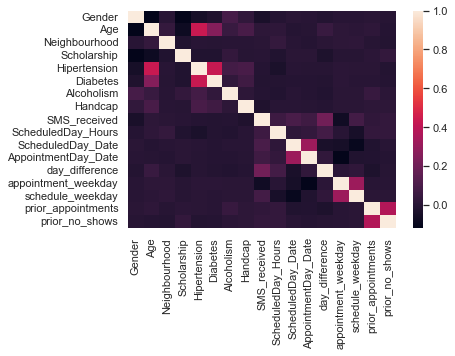

In [23]:
# Visualize the correlation of each feature
y = df.pop('No-show').astype(int)
X = df.copy().astype(int)

corr = X.corr()
sns.heatmap(corr,
            xticklabels = corr.columns,
            yticklabels = corr.columns)
plt.show()

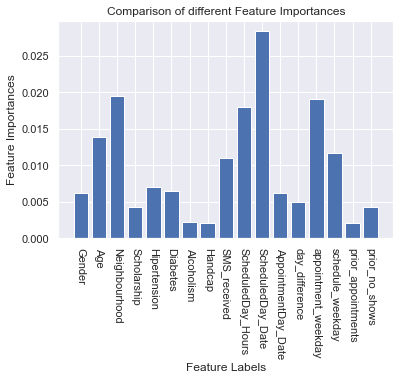

In [24]:
# Visualize the distribution of the importance of each feature
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
extra_tree_forest.fit(X, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in \
                                        extra_tree_forest.estimators_],
                                        axis = 0)

# Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=270)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [25]:
# Drop the features that have low importance
# Drop correlated features
X = X.drop([
            'Hipertension',
            'Diabetes',
            'Alcoholism',
            'Handcap',
            'SMS_received',
            'Scholarship',
            'Neighbourhood'],
             axis =1)

print("This is the final dataset: \n", df.columns)

This is the final dataset: 
 Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'ScheduledDay_Hours', 'ScheduledDay_Date', 'AppointmentDay_Date',
       'day_difference', 'appointment_weekday', 'schedule_weekday',
       'prior_appointments', 'prior_no_shows'],
      dtype='object')


In [26]:
# Dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=30)

## Naive Bayes Modeling

In [27]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1, scoring='f1')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Classification Report is:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     14926
           1       0.58      0.20      0.30      3763

    accuracy                           0.81     18689
   macro avg       0.70      0.58      0.59     18689
weighted avg       0.78      0.81      0.77     18689

the accuracy of this model is:  0.8098881695114774
the F1 of this model is:  0.2985192497532083
the precision of this model is:  0.5806451612903226
the recall of this model is:  0.20090353441403136
The confusion matrix of Naive Bayes is:  
 [[14380   546]
 [ 3007   756]]
The AUC of this model is 0.5821615353967516


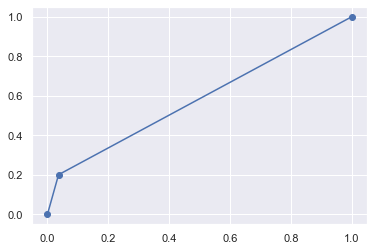

In [28]:
naive_bayes = nbModel_grid.fit(X_train, y_train)
# naive_bayes = MultinomialNB()
 
#Predict on test data
y_predicted_bayes = naive_bayes.predict(X_test)
print("Classification Report is:\n",classification_report(y_test, y_predicted_bayes))
m = confusion_matrix(y_test , y_predicted_bayes)
print("the accuracy of this model is: ",
      accuracy_score(y_test , y_predicted_bayes))
print("the F1 of this model is: ",
      f1_score(y_test , y_predicted_bayes))
print("the precision of this model is: ",
      precision_score(y_test , y_predicted_bayes))
print("the recall of this model is: ",
      recall_score(y_test , y_predicted_bayes))
print("The confusion matrix of Naive Bayes is: ", "\n", m)

# Plotting the ROCCurve of bayes model
fpr_bayes, tpr_bayes, thresold_bayes = roc_curve(y_test, y_predicted_bayes)
AUC = auc(fpr_bayes, tpr_bayes)
print(f"The AUC of this model is {AUC}")
plt.figure()
plt.plot(fpr_bayes, tpr_bayes, marker="o")
plt.show()


## Decision Tree Modeling

In [29]:
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [5, 10, 20,25],
    'min_samples_leaf': [10, 20, 50, 100,120],
    'criterion': ["gini", "entropy"]
}
# grid_search = GridSearchCV(estimator=dt, 
#                            param_grid=params, 
#                            cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=10, n_jobs=-1, verbose=1, scoring = "f1")

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Classification Report is:
               precision    recall  f1-score   support

           0       0.82      0.98      0.90     14926
           1       0.68      0.17      0.28      3763

    accuracy                           0.82     18689
   macro avg       0.75      0.58      0.59     18689
weighted avg       0.79      0.82      0.77     18689

the accuracy of this model is:  0.8168441329124083
the F1 of this model is:  0.2755555555555555
the precision of this model is:  0.6767151767151767
the recall of this model is:  0.17300026574541588
The confusion matrix of decision tree is:  
 [[14615   311]
 [ 3112   651]]
The AUC of this model is 0.5760820704313305


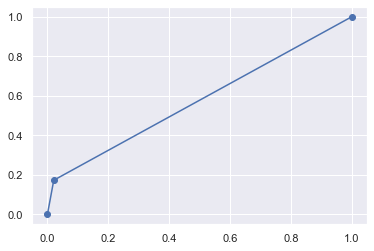

In [30]:
# decision_tree = tree.DecisionTreeClassifier(criterion='gini')
 
#Fitting the data to the classifier
decision_tree = grid_search.fit(X_train, y_train)
y_predicted_tree = decision_tree.predict(X_test)
print("Classification Report is:\n",classification_report(y_test, y_predicted_tree))
m_tree = confusion_matrix(y_test , y_predicted_tree)
print("the accuracy of this model is: ",
      accuracy_score(y_test , y_predicted_tree))
print("the F1 of this model is: ",
      f1_score(y_test , y_predicted_tree))
print("the precision of this model is: ",
      precision_score(y_test , y_predicted_tree))
print("the recall of this model is: ",
      recall_score(y_test , y_predicted_tree))
print("The confusion matrix of decision tree is: ", "\n", m_tree)


# Plotting the ROCCurve of decision tree
fpr_tree, tpr_tree, thresold_tree = roc_curve(y_test, y_predicted_tree)
AUC = auc(fpr_tree, tpr_tree)
print(f"The AUC of this model is {AUC}")
plt.figure()
plt.plot(fpr_tree, tpr_tree, marker="o")
plt.show()

## Support Vector Machine Modeling

In [31]:
model = SVC()
"""
    linear and rbf kernels have the similar and the best performance
    sigmoid kernel is the worst for the dataset
    It will cost forever the time to train the model if I set all the kernels
    So I will use only linear kernel
"""
kernel = ['linear']
C = [0.1, 1, 10, 50]
gamma = ['scale']

# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='f1',error_score=0)

In [32]:
svm = grid_search.fit(X_train, y_train)

the accuracy of this model is:  0.819251966397346
the F1 of this model is:  0.26469307792773183
the precision of this model is:  0.7316486161251504
the recall of this model is:  0.16157321286207812
The confusion matrix of SVM is:  
 [[14703   223]
 [ 3155   608]]
The AUC of this model is 0.5733164201788616


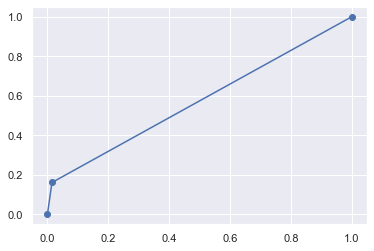

In [33]:
# svm = SVC(kernel='linear', random_state=0, gamma='scale', C=1)
# svm = svm.fit(X_train, y_train)
y_predicted_svm = svm.predict(X_test)

m_svm = confusion_matrix(y_test , y_predicted_svm)
print("the accuracy of this model is: ",
      accuracy_score(y_test , y_predicted_svm))
print("the F1 of this model is: ",
      f1_score(y_test , y_predicted_svm))
print("the precision of this model is: ",
      precision_score(y_test , y_predicted_svm))
print("the recall of this model is: ",
      recall_score(y_test , y_predicted_svm))
print("The confusion matrix of SVM is: ", "\n", m_svm)

# # Plotting the ROCCurve of SVM
fpr_svm, tpr_svm, thresold_svm = roc_curve(y_test, y_predicted_svm)
AUC = auc(fpr_svm, tpr_svm)
print(f"The AUC of this model is {AUC}")
plt.figure()
plt.plot(fpr_svm, tpr_svm, marker="o")
plt.show()


## Random Forest Modeling

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

model = RandomForestClassifier()
n_estimators = [200, 500]
max_features = ['sqrt', 'log2']
max_depth = [1, 5, 8]
class_weight = ['balanced']

grid = dict(n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='f1',error_score=0)

Classification Report is:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83     14926
           1       0.38      0.50      0.43      3763

    accuracy                           0.73     18689
   macro avg       0.62      0.64      0.63     18689
weighted avg       0.76      0.73      0.75     18689


 Accuracy: 
 0.7327839905826957

 F1:
 0.42794959908361974

 Precision score is:
 0.37608214213811153

 Recall score is:
 0.4964124368854637
The confusion matrix of randomforest is:  
 [[11827  3099]
 [ 1895  1868]]
The AUC of this model is 0.5733164201788616


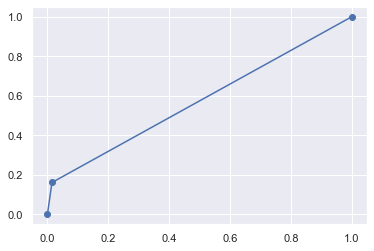

In [35]:
# grid_search = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators= 200, max_depth=8)
rfc = grid_search.fit(X_train, y_train)
rf_pred = rfc.predict(X_test)
m_rfc = confusion_matrix(y_test, rf_pred)
print("Classification Report is:\n",classification_report(y_test,rf_pred))
print("\n Accuracy: \n", accuracy_score(y_test, rf_pred))
print("\n F1:\n",f1_score(y_test,rf_pred))
print("\n Precision score is:\n",precision_score(y_test,rf_pred))
print("\n Recall score is:\n",recall_score(y_test,rf_pred))

print("The confusion matrix of randomforest is: ", "\n", m_rfc)

fpr_rfc, tpr_rfc, thresold_rfc = roc_curve(y_test, y_predicted_svm)
AUC = auc(fpr_rfc, tpr_rfc)
print(f"The AUC of this model is {AUC}")
plt.figure()
plt.plot(fpr_rfc, tpr_rfc, marker="o")
plt.show()

## Analysis of different models
- Overfitting?<br>
  I think the answer is not.
  Because of the unbalance data, the model is not able to learn the data well
  It maybe underfitting
  
- Accuarcy of each model:<br>
  SVM = DT > Naive Bayes > RF

- Precision of each model:<br>
  SVM > DT > Naive Bayes > RF

- Recall of each model:<br>
  RF > Naive Bayes > DT > SVM

- F1 score of each model:<br>
  RF > Naive Bayes > DT > SVM

- AUC of each model:<br>
  Naive Bayes > DT = SVM = RF